In [1]:
# === Setup: Install required packages quietly ===
import sys
import subprocess

def install_packages(packages):
    subprocess.run([sys.executable, "-m", "pip", "install", *packages],
                   stdout=subprocess.DEVNULL,
                   stderr=subprocess.DEVNULL)

required_packages = ['nilearn', 'statsmodels', 'brainspace', 'nibabel', 'matplotlib', 'pandas', 'numpy', 'scipy']
install_packages(required_packages)

# === Imports ===
import os
import re
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nilearn import plotting
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
import nibabel as nib
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from IPython.display import Image, display

# === Functions ===
def eccentricity(g1, g2, g3):
    return np.sqrt(g1**2 + g2**2 + g3**2)

# === Set working directory ===
work_dir = r"C:\Users\ferraras\OneDrive - Université de Genève\Documents\PhD_UNIGE\Project_FC_motivation\B_SNIP1"
os.chdir(work_dir)
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\ferraras\OneDrive - Université de Genève\Documents\PhD_UNIGE\Project_FC_motivation\B_SNIP1


# **Import FC matrices**

In [2]:
# Get sorted list of mat files
files = np.sort(glob.glob("./Glasser_FC_BSNIP/*.mat"))
print(f"Found {len(files)} files.")

# Dictionary to hold FC matrices
fc = {}

for file_path in files:
    # Load mat file
    data = loadmat(file_path)
    
    # Extract matrix (assuming the variable name inside is 'subj_final_corr_mat')
    # Adjust if variable name is different in your files
    mat = data['FC_all'] 
    
    # Optional: if your matrices are 414x414 and you want to use full matrix,
    # no slicing needed here. Otherwise, you can slice if needed.
    # Example: mat = mat[:400, :400]
    
    # Extract subject ID from filename, e.g. 'sub01' from 'sub01_Glasser_FC.mat'
    import re
    match = re.search(r"(sub\d+)", file_path)
    if match:
        subj_id = match.group(1)
    else:
        subj_id = file_path  # fallback
    
    fc[subj_id] = mat

print("Loaded FC matrices")

Found 317 files.
Loaded FC matrices


# **Import demographic data**

In [3]:
# Load your single CSV that includes diagnosis codes (adjust path and filename)
demo = pd.read_csv('bsnip1_gradients.csv')  # or .xlsx with pd.read_excel if needed

# Create DataFrame of FC subject IDs from your dictionary keys
id_df = pd.DataFrame({'participant_id': list(fc.keys())})

# Merge to keep only subjects with FC data
demo = pd.merge(id_df, demo, on='participant_id', how='inner')

# Use 'group_code' as diagnosis numeric code directly
demo['diagnosis'] = demo['group_code']

# If you want a simplified diagnosis grouping (e.g., merge bipolar(3) into schizophrenia(2))
demo['diagnosis2'] = demo['diagnosis'].copy()
demo.loc[demo['diagnosis2'] == 3, 'diagnosis2'] = 2

# Map gender 'M'/'F' to numbers to avoid warnings
demo['gender'] = demo['sex'].map({'M': 1, 'F': 2}).astype(int)

# Inspect
print(demo[['participant_id', 'diagnosis', 'diagnosis2', 'gender', 'interview_age']].head())

  participant_id  diagnosis  diagnosis2  gender  interview_age
0          sub01          1           1       2           45.6
1          sub02          1           1       2           45.6
2          sub03          6           6       2           28.8
3          sub04          6           6       2           28.8
4          sub05          1           1       1           31.2


## **Divide FC per group** ##

In [4]:
fc_SCHZ = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 1]])   # Proband with Schizophrenia
fc_SCHZaff = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 2]])  # Proband with Schizoaffective Disorder
fc_BP = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 3]])      # Proband with Psychotic Bipolar Disorder
fc_REL_SCHZ = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 4]])     # Relative of Proband with Schizophrenia
fc_REL_SCHZaff = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 5]])  # Relative of Proband with Schizoaffective Disorder
fc_REL_BP = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 6]])       # Relative of Proband with Psychotic Bipolar Disorder
fc_CTRL = np.array([fc.get(i) for i in demo['participant_id'][demo['group_code'] == 7]])         # Healthy Control

## **Import atlas** 

In [5]:
# === Step 1: Read parcel names and colors ===
lut = pd.read_csv('Glasser360_Tian_Subcortex_S4_3T_order_info.txt', header=None)

# Extract parcel names (every odd row starting at 0)
lut_names = lut.iloc[0::2, 0].values

# Extract colors (every even row starting at 1), split and convert to int
lut_color = np.array([list(map(int, row.split())) for row in lut.iloc[1::2, 0].values])

# Colors format: ID, R, G, B, A — take RGB columns only (1:4)
rgb_colors = lut_color[:, 1:4]

# Create a ListedColormap normalized to [0,1]
network_cmap = ListedColormap(rgb_colors / 255)

# === Step 2: Read network labels for each parcel ===
network = np.loadtxt('Glasser_Tian_network_labels.txt', dtype=int)

# === Step 3: Define network names (adjust as needed) ===
net_name = ['_','VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN', 'SUB']

# Load atlas (not needed for plotting here, but keep for context)
atlas = nib.load('./Glasser360_Tian_Subcortex_S4_3T.nii').get_fdata()[0]

# **Plot functional connectivity matrices**

In [6]:
# Take only the first 360 x 360 from each subject before averaging
avg_fc_SCHZ = np.mean(fc_SCHZ[:, :360, :360], axis=0)
avg_fc_SCHZaff = np.mean(fc_SCHZaff[:, :360, :360], axis=0)
avg_fc_BP = np.mean(fc_BP[:, :360, :360], axis=0)
avg_fc_REL_SCHZ = np.mean(fc_REL_SCHZ[:, :360, :360], axis=0)
avg_fc_REL_SCHZaff = np.mean(fc_REL_SCHZaff[:, :360, :360], axis=0)
avg_fc_REL_BP = np.mean(fc_REL_BP[:, :360, :360], axis=0)
avg_fc_CTRL = np.mean(fc_CTRL[:, :360, :360], axis=0)

group_dict = {
    'SCHZ': fc_SCHZ,
    'SCHZaff': fc_SCHZaff,
    'BP': fc_BP,
    'REL_SCHZ': fc_REL_SCHZ,
    'REL_SCHZaff': fc_REL_SCHZaff,
    'REL_BP': fc_REL_BP,
    'CTRL': fc_CTRL,
}

avg_fc_dict = {group: np.mean(data, axis=0) for group, data in group_dict.items()}

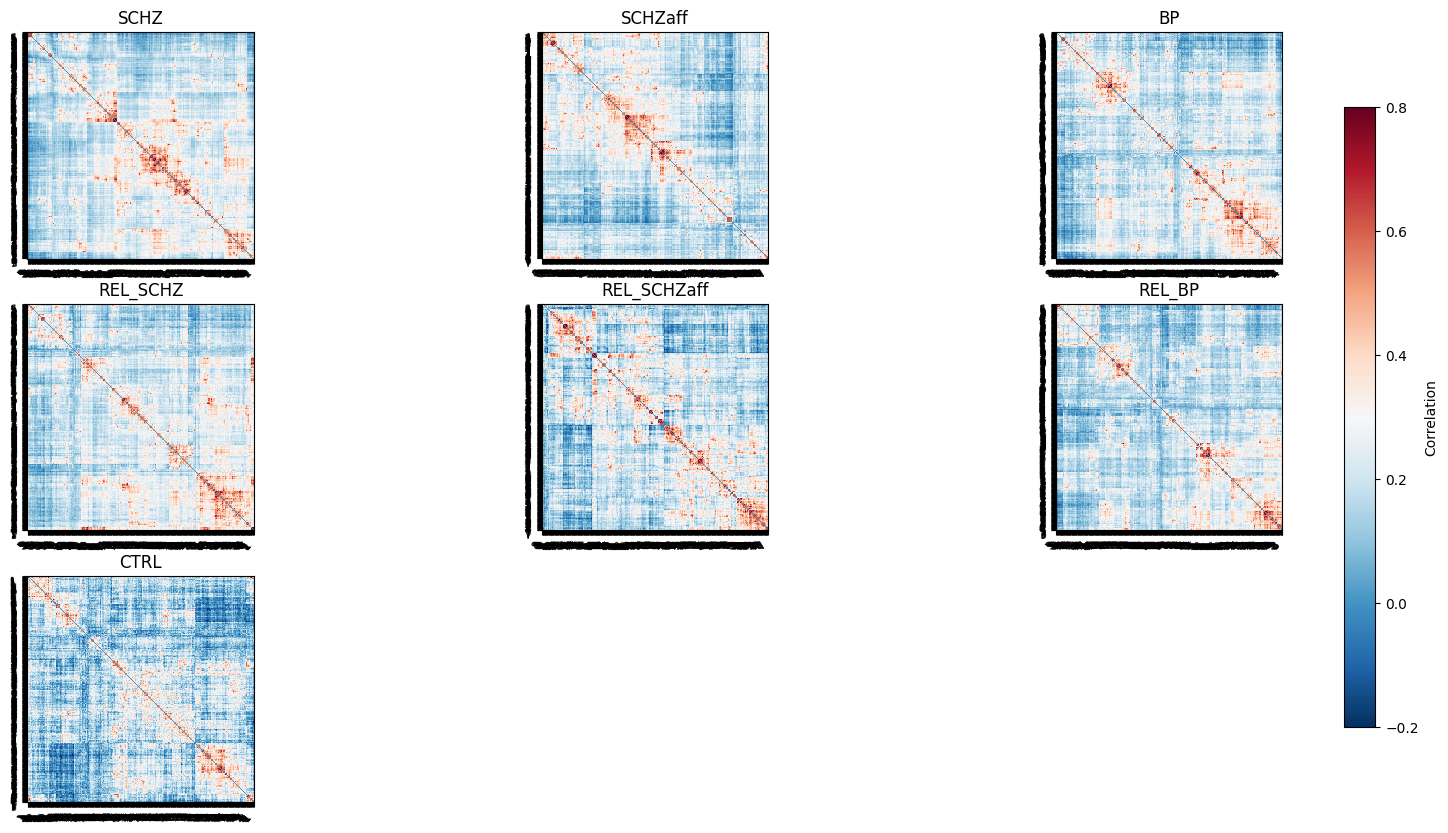

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 7 groups, so 8 subplots but last can be empty
axes = axes.flatten()
groups = list(avg_fc_dict.keys())

for i, group in enumerate(groups):
    display = plotting.plot_matrix(
        avg_fc_dict[group], axes=axes[i],
        labels=network, vmax=0.8, vmin=-0.2, reorder=True, colorbar=False
    )
    axes[i].set_title(group)

# Remove the last empty subplot if you want
if len(groups) < len(axes):
    for j in range(len(groups), len(axes)):
        fig.delaxes(axes[j])

# Add a single colorbar for the whole figure
# `display.img` is the image from the last call to plot_matrix, but its data is a matplotlib image
# so use the last display for the colorbar:
cbar = fig.colorbar(display, ax=axes.tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Correlation')

plt.show()

# **Run gradient analysis**

In [8]:
# Dictionary to hold GradientMaps per group
gradients_dict = {}

# Loop through each group's average FC matrix
for group_name, avg_fc in avg_fc_dict.items():
    # Fit group-level gradients using Diffusion Maps (dm) as reference
    gm = GradientMaps(approach='dm', kernel='normalized_angle', n_components=3, random_state=0)
    gm.fit(avg_fc[:360, :360])  # Use first 360 parcels
    
    gradients_dict[group_name] = gm

# Load surface and labeling
surf_lh, surf_rh = load_conte69()
labeling = np.loadtxt('glasser_360_conte69.csv', dtype=int)
mask = labeling != 0

# Prepare gradients for plotting (map to surface)
gradients_mapped = {}

for group_name, gm in gradients_dict.items():
    grad_group = [
        map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)
        for i in range(3)
    ]
    gradients_mapped[group_name] = grad_group

# Compute global color range across all gradients and all groups
all_vals = np.concatenate([
    np.concatenate(grad_group) for grad_group in gradients_mapped.values()
])
vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
color_range = (vmin, vmax)

## **Plot gradients**

Saving plot for SCHZ


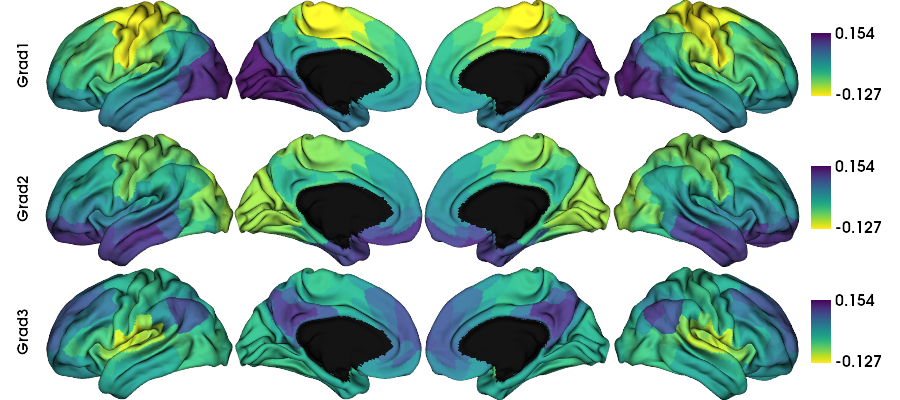

Saving plot for SCHZaff


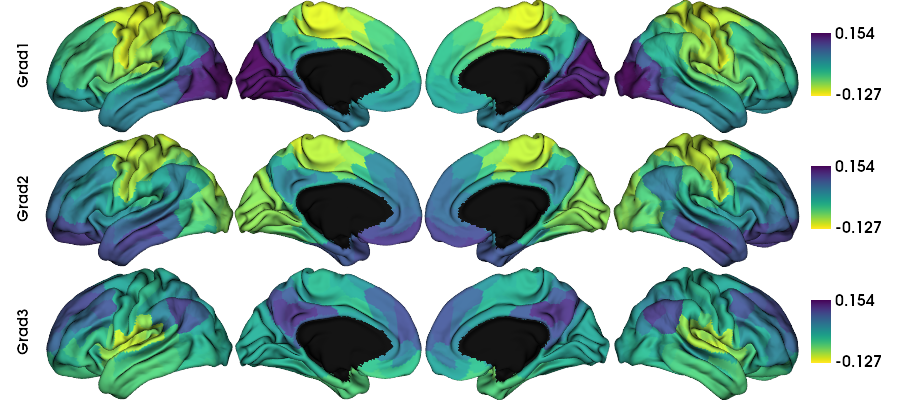

Saving plot for BP


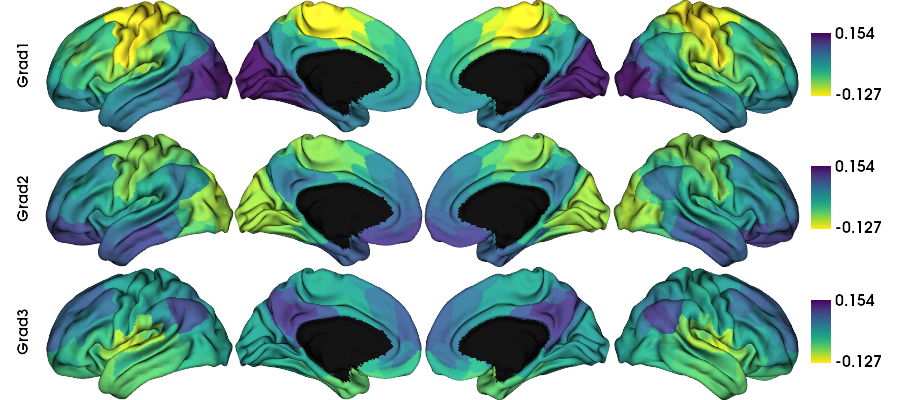

Saving plot for REL_SCHZ


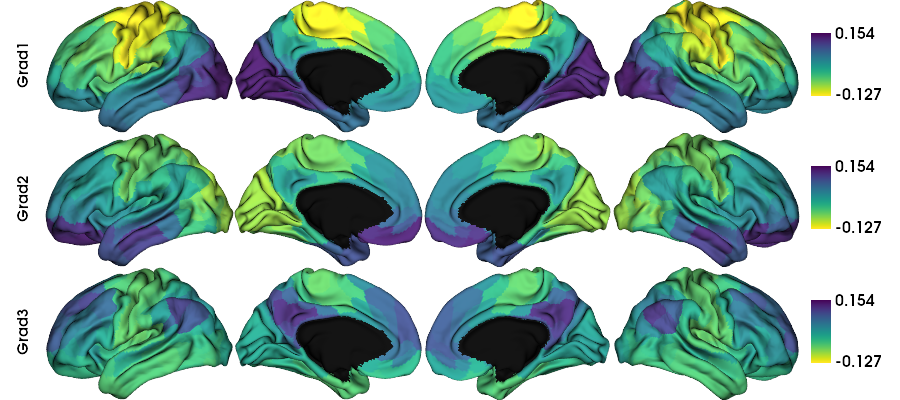

Saving plot for REL_SCHZaff


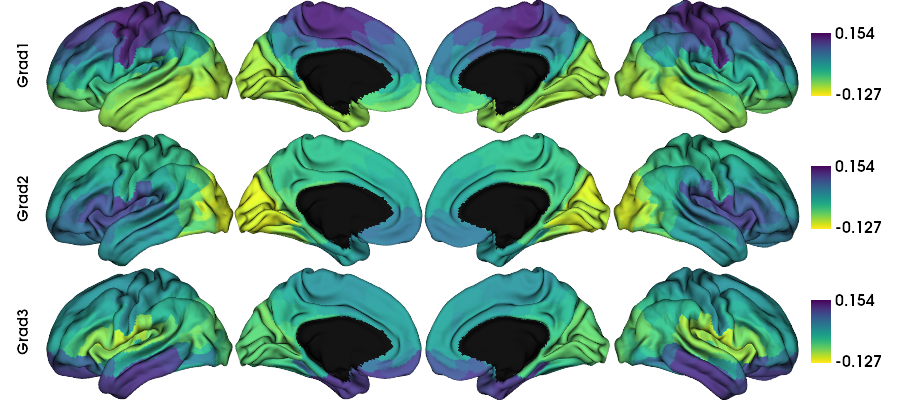

Saving plot for REL_BP


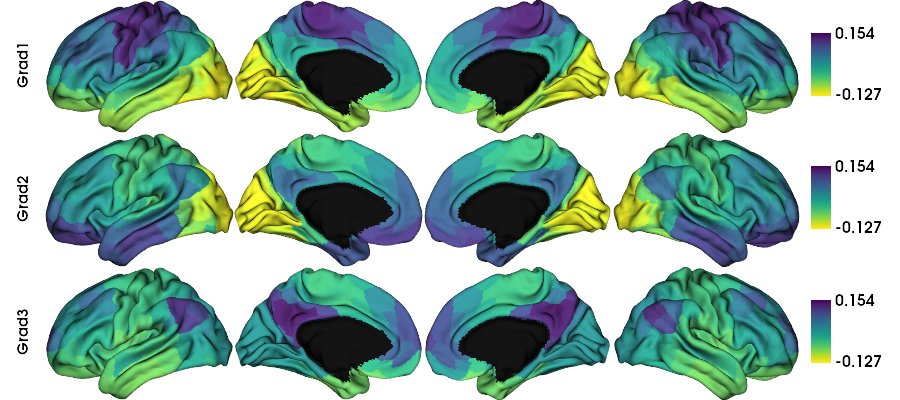

Saving plot for CTRL


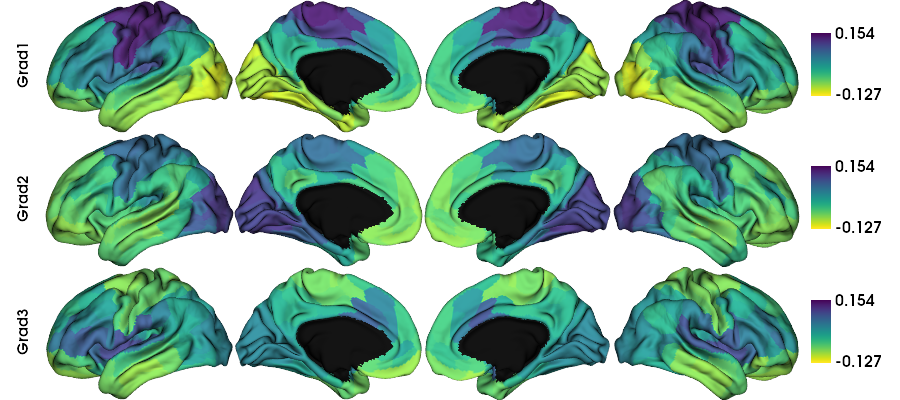

In [9]:
from IPython.display import Image, display

for group_name, grad_group in gradients_mapped.items():
    print(f"Saving plot for {group_name}")
    filename = f"{group_name}_gradient.png"
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=grad_group,
        size=(900, 400),
        cmap='viridis_r',
        color_bar=True,
        label_text=['Grad1', 'Grad2', 'Grad3'],
        zoom=1.8,
        color_range=color_range,
        interactive=False,
        screenshot=True,
        filename=filename
    )
    display(Image(filename))

# **Eccentricity**

Saving eccentricity plot for SCHZ


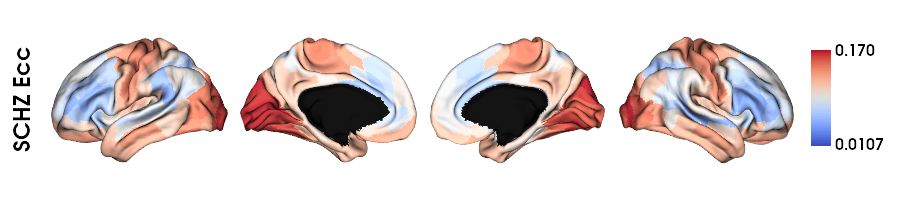

Saving eccentricity plot for SCHZaff


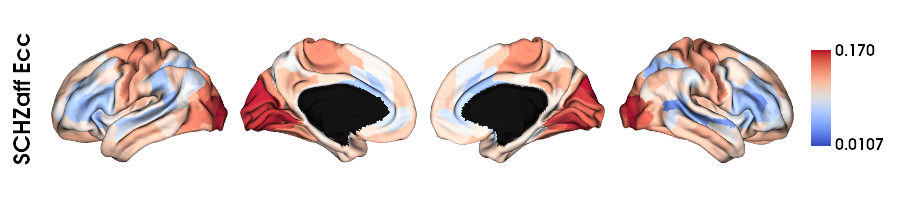

Saving eccentricity plot for BP


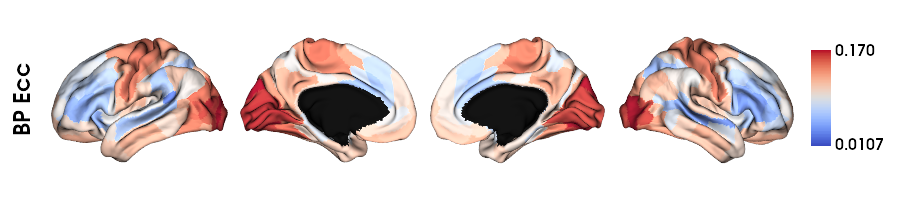

Saving eccentricity plot for REL_SCHZ


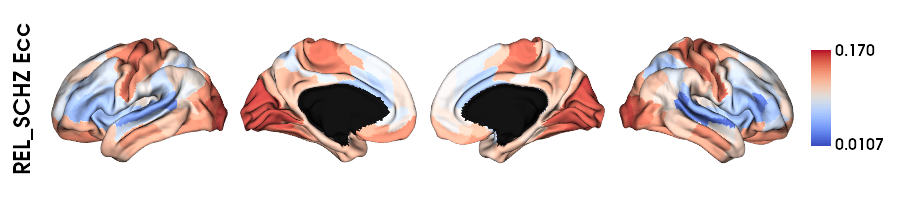

Saving eccentricity plot for REL_SCHZaff


Saving eccentricity plot for REL_BP


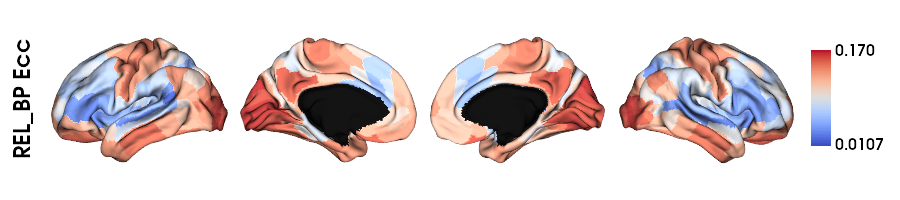

Saving eccentricity plot for CTRL


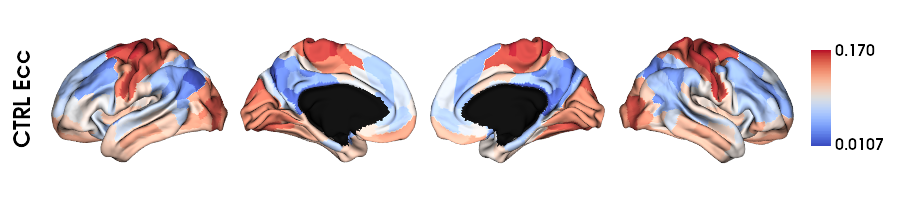

In [10]:
eccentricity_mapped = {}

for group_name, gm in gradients_dict.items():
    ecc = eccentricity(gm.gradients_[:, 0], gm.gradients_[:, 1], gm.gradients_[:, 2])
    ecc_mapped = map_to_labels(ecc, labeling, mask=mask, fill=np.nan)
    eccentricity_mapped[group_name] = ecc_mapped

vmin = np.nanmin(list(eccentricity_mapped.values()))
vmax = np.nanmax(list(eccentricity_mapped.values()))
ecc_color_range = (vmin, vmax)

from IPython.display import Image, display

for group_name, ecc_array in eccentricity_mapped.items():
    print(f"Saving eccentricity plot for {group_name}")
    filename = f"{group_name}_eccentricity.png"
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=ecc_array,
        size=(900, 200),
        cmap='coolwarm',
        color_bar=True,
        label_text=[f"{group_name} Ecc"],
        zoom=1.2,
        color_range=ecc_color_range,
        interactive=False,
        screenshot=True,
        filename=filename
    )
    display(Image(filename))

# **Individual aligned and unaligned gradients**

In [11]:
# Reference gradients from CTRL group
gm_ctrl = gradients_dict['CTRL']

# Prepare dictionaries to hold results for all subjects across groups
gradients_aligned_all = {}   # aligned gradients (360 x 3) per subject
eccen_parcel_aligned_all = {}  # eccentricity per parcel (optional, keep if you want)
eccen_net_aligned_all = {}   # network-averaged eccentricity per subject

# List of all unique diagnosis codes you want to process (exclude CTRL if you want)
diagnosis_codes = demo['diagnosis'].unique()

for diag_code in diagnosis_codes:
    # Filter demo for this group
    demo_group = demo[demo['diagnosis'] == diag_code].reset_index(drop=True)
    if demo_group.empty:
        print(f"No subjects found for diagnosis code {diag_code}, skipping.")
        continue
    
    # Get FC matrices for this group
    # (You can keep this line if you want, but it’s not used below since you access fc by subj_id)
    # fc_group = np.array([fc.get(pid) for pid in demo_group['participant_id']])
    
    for i, subj_id in enumerate(demo_group['participant_id']):
        fc_mat = fc[subj_id][:360, :360]
        
        model = GradientMaps(approach='pca', kernel='normalized_angle', 
                             alignment='procrustes', n_components=3, random_state=0)
        
        model.fit(fc_mat, sparsity=0.9, reference=gm_ctrl.gradients_)
        
        # Store aligned gradients for this subject (360 parcels x 3 gradients)
        gradients_aligned_all[subj_id] = model.aligned_[:360, :].copy()
        
        # Compute eccentricity per parcel (optional, keep for completeness)
        ecc = eccentricity(model.aligned_[:, 0], model.aligned_[:, 1], model.aligned_[:, 2])
        ecc_360 = ecc[:360]
        eccen_parcel_aligned_all[subj_id] = ecc_360
        
        network_360 = network[:360]
        
        # Compute network-average eccentricity (optional, keep for completeness)
        net_avg = []
        for net_id in range(1, 9):
            net_mask = (network_360 == net_id)
            if np.sum(net_mask) == 0:
                net_avg.append(np.nan)
            else:
                net_avg.append(np.nanmean(ecc_360[net_mask]))
        eccen_net_aligned_all[subj_id] = net_avg

print(f"✅ Total subjects processed: {len(gradients_aligned_all)}")


✅ Total subjects processed: 317


In [12]:
# === Parcel-level eccentricity DataFrame ===
df_parcel = pd.DataFrame.from_dict(eccen_parcel_aligned_all, orient='index')
df_parcel.columns = ['node_' + str(i+1) for i in range(df_parcel.shape[1])]
df_parcel = df_parcel.rename_axis('participant_id').reset_index()

# Merge with full demographics table
df_parcel = pd.merge(demo, df_parcel, on='participant_id', how='inner')

# Convert diagnosis and gender to categorical
df_parcel['diagnosis'] = df_parcel['diagnosis'].astype('category')
df_parcel['diagnosis2'] = df_parcel['diagnosis2'].astype('category')
df_parcel['gender'] = df_parcel['gender'].astype('category')

# Now df_parcel looks like your example tmp_df
print(df_parcel.head())


# === Network-level eccentricity DataFrame ===
df_net = pd.DataFrame.from_dict(eccen_net_aligned_all, orient='index')
df_net.columns = ['net_' + str(i+1) for i in range(df_net.shape[1])]
df_net = df_net.rename_axis('participant_id').reset_index()

# Merge with full demographics table
df_net = pd.merge(demo, df_net, on='participant_id', how='inner')

# Convert diagnosis and gender to categorical
df_net['diagnosis'] = df_net['diagnosis'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['gender'] = df_net['gender'].astype('category')

# Now df_net looks like your example net_df
print(df_net.head())


  participant_id        subjectkey  interview_age sex diagnosis  group_code  \
0          sub01  NDAR_INV056VJPL6           45.6   F         1           1   
1          sub02  NDAR_INV056VJPL6           45.6   F         1           1   
2          sub03  NDAR_INV0647UAN8           28.8   F         6           6   
3          sub04  NDAR_INV0647UAN8           28.8   F         6           6   
4          sub05  NDAR_INV0HGGUV9D           31.2   M         1           1   

   group_simple  panss_general  panss_negative  panss_positive  ...  node_351  \
0             1             32              13              19  ...  0.507944   
1             1             32              13              19  ...  1.091948   
2             4             39               9              17  ...  1.066485   
3             4             39               9              17  ...  0.778861   
4             1             39              23              18  ...  1.416914   

   node_352  node_353  node_354  node_

## **Stats CTR vs SCZ p < 0.01**

In [13]:
# Filter dataset for SCHZ (1) and CTRL (7)
df_sub_scz = df_parcel[df_parcel['diagnosis2'].isin([1, 7])].copy()

# Convert diagnosis2 to categorical and reorder so CTRL (7) is baseline/reference
df_sub_scz['diagnosis2'] = df_sub_scz['diagnosis2'].astype('category')
df_sub_scz['diagnosis2'] = df_sub_scz['diagnosis2'].cat.set_categories([7, 1], ordered=True)

# Make gender categorical
df_sub_scz['gender'] = df_sub_scz['gender'].astype('category')
n_nodes = 360

models_scz = [None] * n_nodes

for i in range(n_nodes):
    node_col = f'node_{i+1}'
    formula = f'{node_col} ~ C(diagnosis2) + interview_age + C(gender)'
    models_scz[i] = smf.ols(formula, data=df_sub_scz).fit()

pvals_diag_scz = np.array([models_scz[i].pvalues.get('C(diagnosis2)[T.1]', np.nan) for i in range(n_nodes)])
tvals_diag_scz = np.array([models_scz[i].tvalues.get('C(diagnosis2)[T.1]', 0) for i in range(n_nodes)])

# FDR correction for age and gender as before
pvals_age_scz = np.array([models_scz[i].pvalues.get('interview_age', np.nan) for i in range(n_nodes)])
pvals_gender_scz = np.array([models_scz[i].pvalues.get('C(gender)[T.2]', np.nan) for i in range(n_nodes)])
_, pvals_age_fdr_scz = fdrcorrection(pvals_age_scz, alpha=0.05)
_, pvals_gender_fdr_scz = fdrcorrection(pvals_gender_scz, alpha=0.05)

# Threshold t-values by significance
tvals_diag_scz[pvals_diag_scz > 0.01] = 0
tvals_age_scz = np.array([models_scz[i].tvalues.get('interview_age', 0) for i in range(n_nodes)])
tvals_age_scz[pvals_age_fdr_scz > 0.05] = 0
tvals_gender_scz = np.array([models_scz[i].tvalues.get('C(gender)[T.2]', 0) for i in range(n_nodes)])
tvals_gender_scz[pvals_gender_fdr_scz > 0.05] = 0

tvals_dict_scz = {
    'Diagnosis2': tvals_diag_scz,
    'Age': tvals_age_scz,
    'Gender': tvals_gender_scz
}

ecc_color_range = (-3, 3)  # example color range for t-values

Plotting Diagnosis2 t-values


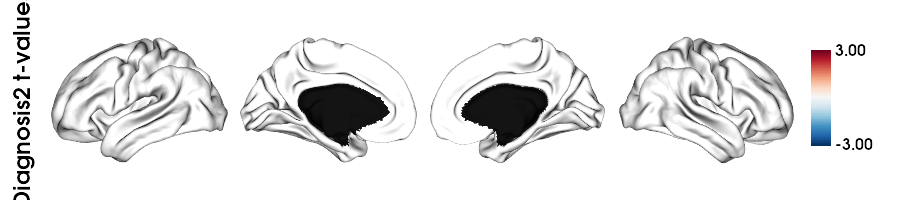

Plotting Age t-values


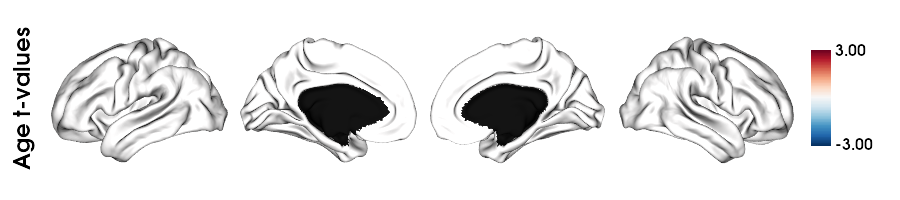

Plotting Gender t-values


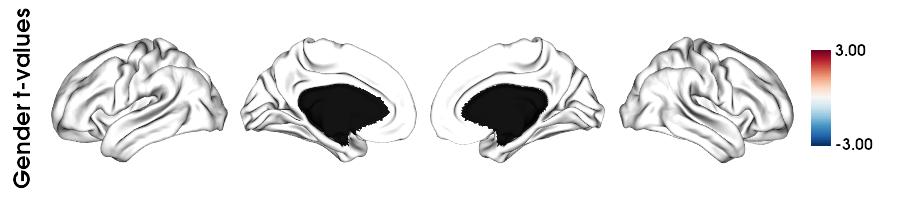

In [14]:
mask = labeling != 0
mapped_tvals = dict()

for name, tvals in tvals_dict_scz.items():
    # map parcel-wise t-values to vertices
    mapped_array = map_to_labels(tvals, labeling, mask=mask, fill=np.nan)
    mapped_tvals[name] = mapped_array

for name, vertex_data in mapped_tvals.items():
    print(f"Plotting {name} t-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,  # ✅ full-length 64984 array
        size=(900, 200),
        cmap='RdBu_r',
        color_bar=True,
        label_text=[f"{name} t-values"],
        zoom=1.2,
        color_range=(-3, 3),
        interactive=False,
        screenshot=True,
        filename=f"{name}_tvals_plot.png"
    )
    display(Image(f"{name}_tvals_plot.png"))


In [15]:
# Make sure categorical variables are set up properly
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].cat.set_categories([7, 1], ordered=True)  # 7 = CTRL, 1 = SCHZ
df_net['gender'] = df_net['gender'].astype('category')

# Fit models for net_1 to net_7
models = []
for i in range(7):  # net_1 to net_7
    net_col = f'net_{i+1}'
    formula = f'{net_col} ~ C(diagnosis2) + interview_age + C(gender)'
    model = smf.ols(formula, data=df_net).fit()
    models.append(model)

# Extract t-values and p-values for diagnosis effect
tvals = np.array([m.tvalues.get('C(diagnosis2)[T.1]', np.nan) for m in models])
pvals = np.array([m.pvalues.get('C(diagnosis2)[T.1]', np.nan) for m in models])
_, pvals_fdr = fdrcorrection(pvals, alpha=0.05)

# Create summary DataFrame
sts = pd.DataFrame({
    'Network': net_name[1:8],
    't-value (diagnosis2)': tvals,
    'p-value': pvals,
    'FDR-corrected p': pvals_fdr
})

# Optional: Display nicely
sts.style.set_caption("SCHZ vs CTRL: Network-Level T-values")

## **Stats CTR vs SCZ affective p < 0.01**

In [16]:
# Filter dataset for SCHZaff (2) and CTRL (7)
df_sub_aff = df_parcel[df_parcel['diagnosis2'].isin([2, 7])].copy()

# Convert diagnosis2 to categorical and reorder so CTRL (7) is baseline/reference
df_sub_aff['diagnosis2'] = df_sub_aff['diagnosis2'].astype('category')
df_sub_aff['diagnosis2'] = df_sub_aff['diagnosis2'].cat.set_categories([7, 2], ordered=True)

# Make gender categorical
df_sub_aff['gender'] = df_sub_aff['gender'].astype('category')

models_aff = [None] * n_nodes

for i in range(n_nodes):
    node_col = f'node_{i+1}'
    formula = f'{node_col} ~ C(diagnosis2) + interview_age + C(gender)'
    models_aff[i] = smf.ols(formula, data=df_sub_aff).fit()

pvals_diag_aff = np.array([models_aff[i].pvalues.get('C(diagnosis2)[T.2]', np.nan) for i in range(n_nodes)])
tvals_diag_aff = np.array([models_aff[i].tvalues.get('C(diagnosis2)[T.2]', 0) for i in range(n_nodes)])

# FDR correction for age and gender as before
pvals_age_aff = np.array([models_aff[i].pvalues.get('interview_age', np.nan) for i in range(n_nodes)])
pvals_gender_aff = np.array([models_aff[i].pvalues.get('C(gender)[T.2]', np.nan) for i in range(n_nodes)])
_, pvals_age_fdr_aff = fdrcorrection(pvals_age_aff, alpha=0.05)
_, pvals_gender_fdr_aff = fdrcorrection(pvals_gender_aff, alpha=0.05)

# Threshold t-values by significance
tvals_diag_aff[pvals_diag_aff > 0.01] = 0
tvals_age_aff = np.array([models_aff[i].tvalues.get('interview_age', 0) for i in range(n_nodes)])
tvals_age_aff[pvals_age_fdr_aff > 0.05] = 0
tvals_gender_aff = np.array([models_aff[i].tvalues.get('C(gender)[T.2]', 0) for i in range(n_nodes)])
tvals_gender_aff[pvals_gender_fdr_aff > 0.05] = 0

tvals_dict_aff = {
    'Diagnosis2': tvals_diag_aff,
    'Age': tvals_age_aff,
    'Gender': tvals_gender_aff
}

ecc_color_range = (-3, 3)  # example color range for t-values

Plotting Diagnosis2 t-values


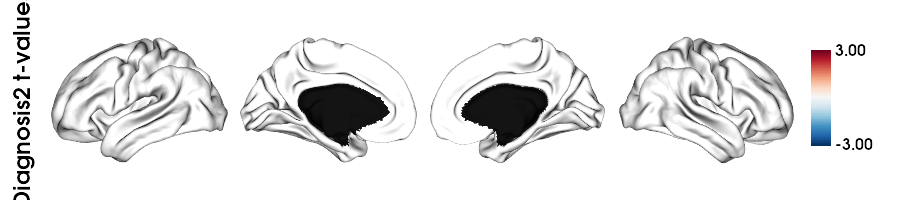

Plotting Age t-values


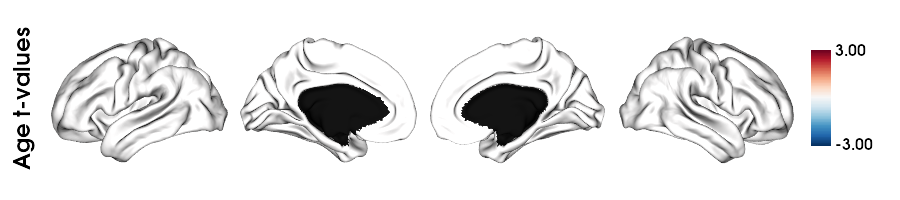

Plotting Gender t-values


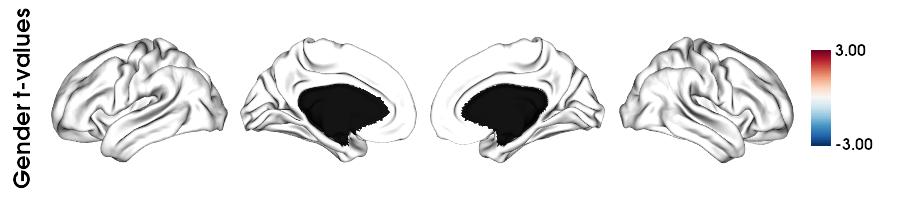

In [17]:
mask = labeling != 0
mapped_tvals = dict()

for name, tvals in tvals_dict_aff.items():
    # map parcel-wise t-values to vertices
    mapped_array = map_to_labels(tvals, labeling, mask=mask, fill=np.nan)
    mapped_tvals[name] = mapped_array

for name, vertex_data in mapped_tvals.items():
    print(f"Plotting {name} t-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,  # ✅ full-length 64984 array
        size=(900, 200),
        cmap='RdBu_r',
        color_bar=True,
        label_text=[f"{name} t-values"],
        zoom=1.2,
        color_range=(-3, 3),
        interactive=False,
        screenshot=True,
        filename=f"{name}_tvals_plot.png"
    )
    display(Image(f"{name}_tvals_plot.png"))

In [18]:
# Make sure categorical variables are set up properly
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].cat.set_categories([7, 2], ordered=True)  # 7 = CTRL, 2 = SCHZ affective
df_net['gender'] = df_net['gender'].astype('category')

# Fit models for net_1 to net_7
models = []
for i in range(7):  # net_1 to net_7
    net_col = f'net_{i+1}'
    formula = f'{net_col} ~ C(diagnosis2) + interview_age + C(gender)'
    model = smf.ols(formula, data=df_net).fit()
    models.append(model)

# Extract t-values and p-values for diagnosis effect
tvals = np.array([m.tvalues.get('C(diagnosis2)[T.2]', np.nan) for m in models])
pvals = np.array([m.pvalues.get('C(diagnosis2)[T.2]', np.nan) for m in models])
_, pvals_fdr = fdrcorrection(pvals, alpha=0.05)

# Create summary DataFrame
sts = pd.DataFrame({
    'Network': net_name[1:8],
    't-value (diagnosis2)': tvals,
    'p-value': pvals,
    'FDR-corrected p': pvals_fdr
})

# Optional: Display nicely
sts.style.set_caption("SCHZ aff vs CTRL: Network-Level T-values")

## **Stats CTR vs BD affective p < 0.01**

In [19]:
# Filter dataset for SCHZaff (2) and CTRL (7)
df_sub_bd = df_parcel[df_parcel['diagnosis2'].isin([3, 7])].copy()

# Convert diagnosis2 to categorical and reorder so CTRL (7) is baseline/reference
df_sub_bd['diagnosis2'] = df_sub_bd['diagnosis2'].astype('category')
df_sub_bd['diagnosis2'] = df_sub_bd['diagnosis2'].cat.set_categories([7, 3], ordered=True)

# Make gender categorical
df_sub_bd['gender'] = df_sub_bd['gender'].astype('category')

models_bd = [None] * n_nodes

for i in range(n_nodes):
    node_col = f'node_{i+1}'
    formula = f'{node_col} ~ C(diagnosis2) + interview_age + C(gender)'
    models_bd[i] = smf.ols(formula, data=df_sub_bd).fit()

pvals_diag_bd = np.array([models_bd[i].pvalues.get('C(diagnosis2)[T.3]', np.nan) for i in range(n_nodes)])
tvals_diag_bd = np.array([models_bd[i].tvalues.get('C(diagnosis2)[T.3]', 0) for i in range(n_nodes)])

# FDR correction for age and gender as before
pvals_age_bd = np.array([models_bd[i].pvalues.get('interview_age', np.nan) for i in range(n_nodes)])
pvals_gender_bd = np.array([models_bd[i].pvalues.get('C(gender)[T.2]', np.nan) for i in range(n_nodes)])
_, pvals_age_fdr_bd = fdrcorrection(pvals_age_bd, alpha=0.05)
_, pvals_gender_fdr_bd = fdrcorrection(pvals_gender_bd, alpha=0.05)

# Threshold t-values by significance
tvals_diag_bd[pvals_diag_bd > 0.01] = 0
tvals_age_bd = np.array([models_bd[i].tvalues.get('interview_age', 0) for i in range(n_nodes)])
tvals_age_bd[pvals_age_fdr_bd > 0.05] = 0
tvals_gender_bd = np.array([models_bd[i].tvalues.get('C(gender)[T.2]', 0) for i in range(n_nodes)])
tvals_gender_bd[pvals_gender_fdr_bd > 0.05] = 0

tvals_dict_bd = {
    'Diagnosis2': tvals_diag_bd,
    'Age': tvals_age_bd,
    'Gender': tvals_gender_bd
}

ecc_color_range = (-3, 3)  # example color range for t-values

Plotting Diagnosis2 t-values


Plotting Age t-values


Plotting Gender t-values


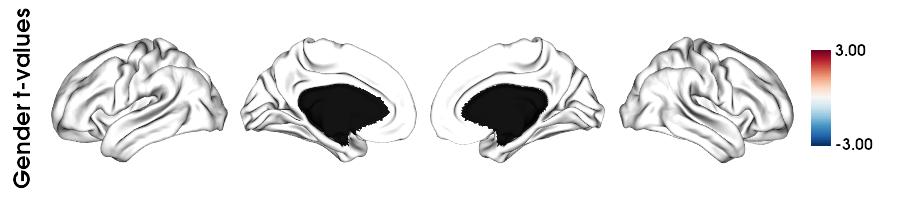

In [20]:
mask = labeling != 0
mapped_tvals = dict()

for name, tvals in tvals_dict_bd.items():
    # map parcel-wise t-values to vertices
    mapped_array = map_to_labels(tvals, labeling, mask=mask, fill=np.nan)
    mapped_tvals[name] = mapped_array

for name, vertex_data in mapped_tvals.items():
    print(f"Plotting {name} t-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,  # ✅ full-length 64984 array
        size=(900, 200),
        cmap='RdBu_r',
        color_bar=True,
        label_text=[f"{name} t-values"],
        zoom=1.2,
        color_range=(-3, 3),
        interactive=False,
        screenshot=True,
        filename=f"{name}_tvals_plot.png"
    )
    display(Image(f"{name}_tvals_plot.png"))

In [21]:
# Make sure categorical variables are set up properly
df_net['diagnosis2'] = df_net['diagnosis2'].astype('category')
df_net['diagnosis2'] = df_net['diagnosis2'].cat.set_categories([7, 3], ordered=True)  # 7 = CTRL, 3 = BD
df_net['gender'] = df_net['gender'].astype('category')

# Fit models for net_1 to net_7
models = []
for i in range(7):  # net_1 to net_7
    net_col = f'net_{i+1}'
    formula = f'{net_col} ~ C(diagnosis2) + interview_age + C(gender)'
    model = smf.ols(formula, data=df_net).fit()
    models.append(model)

# Extract t-values and p-values for diagnosis effect
tvals = np.array([m.tvalues.get('C(diagnosis2)[T.3]', np.nan) for m in models])
pvals = np.array([m.pvalues.get('C(diagnosis2)[T.3]', np.nan) for m in models])
_, pvals_fdr = fdrcorrection(pvals, alpha=0.05)

# Create summary DataFrame
sts = pd.DataFrame({
    'Network': net_name[1:8],
    't-value (diagnosis2)': tvals,
    'p-value': pvals,
    'FDR-corrected p': pvals_fdr
})

# Optional: Display nicely
sts.style.set_caption("BD vs CTRL: Network-Level T-values")

# **Multivariate - Hotelling's T**

In [22]:
import numpy as np
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.tools import add_constant
from statsmodels.stats.multitest import multipletests

# Participants and parcels info
participants = list(gradients_aligned_all.keys())  # from previous step
n_participants = len(participants)
n_parcels = 360
n_gradients = 3

# Initialize 3D array: participants x parcels x gradients
gradients_all = np.zeros((n_participants, n_parcels, n_gradients))
f_mv = np.zeros(360)
p_mv = np.zeros(360)

# Fill gradients_all from your aligned gradients dict
for i, pid in enumerate(participants):
    gradients_all[i, :, :] = gradients_aligned_all[pid]

# Prepare dataframe with participant info, ensuring matching order with gradients_all
df = demo[demo['participant_id'].isin(participants)].copy()
df = df.set_index('participant_id').loc[participants].reset_index()

# Convert categorical variables
df['diagnosis'] = df['diagnosis'].astype('category')
df['gender'] = df['gender'].astype('category')

for parcel_idx in range(n_parcels):
    Y = gradients_all[:, parcel_idx, :]  # (n_participants, 3)
    
    # Create DataFrame for participants order
    df_participants = df.copy()
    
    # Drop rows with missing data in predictors or response if needed
    mask = ~df_participants[['interview_age']].isna().any(axis=1)
    
    df_sub = df_participants[mask].reset_index(drop=True)
    
    # Filter Y accordingly
    Y_sub = Y[mask.values, :]
    
    # Construct design matrix
    X = pd.get_dummies(df_sub[['diagnosis', 'interview_age', 'gender']], drop_first=True)
    X = add_constant(X).astype(float)
    
    # Run MANOVA
    manova = MANOVA(endog=Y_sub, exog=X)
    res = manova.mv_test()
    
    f_mv[parcel_idx] = res.results['x1']['stat']['F Value']['Hotelling-Lawley trace']
    p_mv[parcel_idx] = res.results['x1']['stat']['Pr > F']['Hotelling-Lawley trace']

# Multiple comparison correction (FDR)
reject, pvals_corrected, _, _ = multipletests(p_mv, alpha=0.05, method='fdr_bh')

# Threshold F-values by significance
significant_f = f_mv.copy()
significant_f[~reject] = 0  # zero out non-significant parcels

In [23]:
mask = (labeling != 0)  # only vertices with a parcel label

mapped_fvals = {}

for name, fvals in {'Hotelling_F': f_mv}.items():
    # fvals length = number of parcels (360)
    # labeling length = number of vertices (e.g., 64984)
    mapped_array = map_to_labels(fvals, labeling, mask=mask, fill=np.nan)
    mapped_fvals[name] = mapped_array

for name, vertex_data in mapped_fvals.items():
    print(f"Plotting {name} F-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,
        size=(900, 200),
        cmap='Oranges',
        color_bar=True,
        label_text=[f"{name} values"],
        zoom=1.2,
        color_range=(0, np.nanmax(vertex_data)),
        interactive=False,
        screenshot=True,
        filename=f"{name}_fvals_plot.png"
    )
    display(Image(f"{name}_fvals_plot.png"))

Plotting Hotelling_F F-values


In [24]:
import numpy as np
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.tools import add_constant
from statsmodels.stats.multitest import multipletests

# --- Network Info ---
# Assuming `network` is an array of length 360, with values 1-7 for cortical networks
# and you've excluded 0 (unlabeled) and 8+ (subcortex)
cortical_networks = range(1, 8)
net_name = ['VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

# --- Step 1: Average gradients per participant per network ---
n_participants, n_parcels, n_gradients = gradients_all.shape
n_networks = len(cortical_networks)

# Initialize: gradients by network, shape = (participants, networks, gradients)
gradients_network = np.zeros((n_participants, n_networks, n_gradients))

for i, net_id in enumerate(cortical_networks):
    mask = network_360 == net_id
    gradients_network[:, i, :] = gradients_all[:, mask, :].mean(axis=1)

# --- Step 2: Prepare predictors (design matrix) ---
X = pd.get_dummies(df[['diagnosis', 'interview_age', 'gender']], drop_first=True)
X = add_constant(X).astype(float)

# --- Step 3: Run MANOVA for each network ---
f_mv_net = np.zeros(n_networks)
p_mv_net = np.zeros(n_networks)

for i in range(n_networks):
    Y_net = gradients_network[:, i, :]  # shape: (participants, 3)

    # Drop any participants with NaNs
    mask = ~np.isnan(Y_net).any(axis=1)
    Y_net_sub = Y_net[mask]
    X_sub = X.loc[mask, :]

    # Fit MANOVA
    manova = MANOVA(endog=Y_net_sub, exog=X_sub)
    res = manova.mv_test()

    f_mv_net[i] = res.results['x1']['stat']['F Value']['Hotelling-Lawley trace']
    p_mv_net[i] = res.results['x1']['stat']['Pr > F']['Hotelling-Lawley trace']

# --- Step 4: FDR correction ---
_, p_mv_net_fdr, _, _ = multipletests(p_mv_net, alpha=0.05, method='fdr_bh')

# --- Step 5: Format results ---
sts = pd.DataFrame({
    'Network': net_name,
    'F Value': f_mv_net,
    'p-value': p_mv_net,
    'p-FDR': p_mv_net_fdr
})

# Optional: Style for notebook
sts.style.set_caption("Multivariate MANOVA for 7 Networks")

# **Gradient 1 analysis**

### **Extracting the first aligned gradient (gradient 1, since g_n=0) from all participants, computing both parcel-level and network-level means**

In [25]:
# Assume you have:
# gradients_all: numpy array, shape (n_participants, n_parcels=360, n_gradients=3)
# network: numpy array, length = n_parcels (360), with network labels 1-7 for each parcel
# df: participant dataframe with columns including 'participant_id', 'diagnosis', 'gender', etc.
# participants: list of participant IDs in order matching gradients_all

g_n = 0  # gradient index, 0-based (0=gradient1)

# Step 1: Extract individual gradient values per participant (parcel-level)
g = {}
for i, pid in enumerate(participants):
    # Extract gradient n values across all parcels for participant i
    g[pid] = gradients_all[i, :, g_n]

# Step 2: Calculate mean gradient per network per participant
n_networks = 7
g_net = {}
for i, pid in enumerate(participants):
    g_net[pid] = np.zeros(n_networks)
    for net_id in range(1, n_networks + 1):
        mask = network == net_id
        g_net[pid][net_id - 1] = gradients_all[i, mask[:360], g_n].mean()

# Step 3: Create DataFrame for parcel-level gradients
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' + str(i+1) for i in range(tmp_df.shape[1])]
tmp_df.index.name = 'participant_id'
tmp_df.reset_index(inplace=True)

# Step 4: Merge with participant metadata
tmp_df = pd.merge(df, tmp_df, on='participant_id')

# Step 5: Add categorical data conversions if needed
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
if 'diagnosis2' in tmp_df.columns:
    tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')

# Optional: Create a DataFrame for network-level means and merge
tmp_df_net = pd.DataFrame.from_dict(g_net, orient='index')
tmp_df_net.columns = ['network_' + str(i+1) for i in range(n_networks)]
tmp_df_net.index.name = 'participant_id'
tmp_df_net.reset_index(inplace=True)
tmp_df = pd.merge(tmp_df, tmp_df_net, on='participant_id')

# Step 6: Save to CSV
tmp_df.to_csv('gradient1_aligned_with_metadata.csv', index=False)

# Display resulting DataFrame
print(tmp_df.head())


  participant_id        subjectkey  interview_age sex diagnosis  group_code  \
0          sub01  NDAR_INV056VJPL6           45.6   F         1           1   
1          sub02  NDAR_INV056VJPL6           45.6   F         1           1   
2          sub05  NDAR_INV0HGGUV9D           31.2   M         1           1   
3          sub06  NDAR_INV0HGGUV9D           31.2   M         1           1   
4          sub07  NDAR_INV0NZ2AJ6W           33.6   M         1           1   

   group_simple  panss_general  panss_negative  panss_positive  ...  node_358  \
0             1             32              13              19  ... -0.992095   
1             1             32              13              19  ...  0.250421   
2             1             39              23              18  ... -0.435213   
3             1             39              23              18  ... -0.028381   
4             1             19              17               7  ...  0.018335   

   node_359  node_360  network_1  netw

### **Network-level gradients merged with participant info**

In [26]:
# Create DataFrame from network-level gradients dictionary
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' + str(i+1) for i in range(net_df.shape[1])]
net_df.index.name = 'participant_id'
net_df.reset_index(inplace=True)

# Merge with participant metadata DataFrame
net_df = pd.merge(df, net_df, on='participant_id')

# Convert categorical variables
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
if 'diagnosis2' in net_df.columns:
    net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')

# Save to CSV
net_df.to_csv('gradient1_network_aligned.csv', index=False)

# Display the resulting DataFrame
print(net_df.head())


  participant_id        subjectkey  interview_age sex diagnosis  group_code  \
0          sub01  NDAR_INV056VJPL6           45.6   F         1           1   
1          sub02  NDAR_INV056VJPL6           45.6   F         1           1   
2          sub05  NDAR_INV0HGGUV9D           31.2   M         1           1   
3          sub06  NDAR_INV0HGGUV9D           31.2   M         1           1   
4          sub07  NDAR_INV0NZ2AJ6W           33.6   M         1           1   

   group_simple  panss_general  panss_negative  panss_positive  ...  gps_g16  \
0             1             32              13              19  ...        1   
1             1             32              13              19  ...        1   
2             1             39              23              18  ...        5   
3             1             39              23              18  ...        5   
4             1             19              17               7  ...        1   

   diagnosis2  gender     net_1     net_2   

In [27]:
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import numpy as np

# Assuming tmp_df is your DataFrame with columns: 'node_1', 'node_2', ..., 'node_400' + covariates

n_nodes = 360
model = [None] * n_nodes

# Fit OLS for each node
for i in range(n_nodes):
    formula = f'node_{i+1} ~ C(diagnosis2) + interview_age + C(gender)'
    model[i] = smf.ols(formula, data=tmp_df).fit()

# Extract t-values for each predictor
t_diag2 = np.array([m.tvalues.get('C(diagnosis2)[T.2]', 0) for m in model])
t_age = np.array([m.tvalues.get('interview_age', 0) for m in model])
t_gender = np.array([m.tvalues.get('C(gender)[T.2]', 0) for m in model])

# Extract p-values
p_diag2 = np.array([m.pvalues.get('C(diagnosis2)[T.2]', 1) for m in model])
p_age = np.array([m.pvalues.get('interview_age', 1) for m in model])
p_gender = np.array([m.pvalues.get('C(gender)[T.2]', 1) for m in model])

# Apply thresholds: example threshold 0.017 for diagnosis2, FDR for others
threshold_diag2 = 0.017
reject_age, p_fdr_age, _, _ = multipletests(p_age, alpha=0.05, method='fdr_bh')
reject_gender, p_fdr_gender, _, _ = multipletests(p_gender, alpha=0.05, method='fdr_bh')

t_diag2[p_diag2 > threshold_diag2] = 0
t_age[~reject_age] = 0
t_gender[~reject_gender] = 0

# Prepare list of arrays for plotting
t_values = [t_diag2, t_age, t_gender]

plot = [None] * len(t_values)
for i, t_arr in enumerate(t_values):
    plot[i] = atlas.copy().astype(float)
    for j in range(n_nodes):
        plot[i][atlas == j+1] = t_arr[j]
    plot[i][atlas == 0] = np.nan  # Mask background


Plotting diagnosis2 t-values


Plotting interview_age t-values


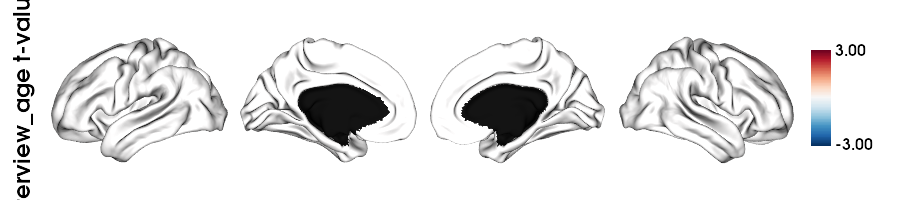

Plotting gender t-values


In [28]:
from IPython.display import Image, display
import numpy as np

# Assume these are your t-values arrays from the previous regression:
# For example:
# t_diag = np.array([...])  # shape: n_parcels (e.g., 360 or 400)
# t_age = np.array([...])
# t_gender = np.array([...])

# Also assume you have:
# labeling = your parcel-to-vertex labeling array (1D with length = number of vertices)
# mask = boolean mask for vertices of interest (same length as labeling)
# surf_lh, surf_rh = left and right hemisphere surface mesh objects

effect_labels = ['diagnosis2', 'interview_age', 'gender']
effects = [t_diag2, t_age, t_gender]
mask = labeling != 0
mapped_tvals = {}

for name, tvals in zip(effect_labels, effects):
    # Map parcel-wise t-values onto surface vertices, filling others with NaN
    mapped_array = map_to_labels(tvals, labeling, mask=mask, fill=np.nan)
    mapped_tvals[name] = mapped_array

# Plot each effect on the surface
for name, vertex_data in mapped_tvals.items():
    print(f"Plotting {name} t-values")
    plot_hemispheres(
        surf_lh, surf_rh,
        array_name=vertex_data,
        size=(900, 200),
        cmap='RdBu_r',
        color_bar=True,
        label_text=[f"{name} t-values"],
        zoom=1.2,
        color_range=(-3, 3),
        interactive=False,
        screenshot=True,
        filename=f"tval_plot_{name}.png"
    )
    display(Image(f"tval_plot_{name}.png"))


In [29]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Assuming net_df has columns: 'participant_id', 'diagnosis2', 'interview_age', 'gender', 'net_1'...'net_7'
# And net_name is the list of network names, e.g., ['Network1', 'Network2', ..., 'Network7']

diagnosis_levels = net_df['diagnosis2'].cat.categories.tolist()
results_list = []

# Loop over all pairs of diagnosis groups
for diag1, diag2 in combinations(diagnosis_levels, 2):
    # Filter data to only these two diagnosis groups
    df = net_df[net_df['diagnosis2'].isin([diag1, diag2])].copy()
    
    # Recode diagnosis2 to have only two levels (this avoids multilevel contrasts)
    df['diagnosis2'] = df['diagnosis2'].cat.remove_unused_categories()
    
    models = []
    for i in range(7):
        formula = f'net_{i+1} ~ C(diagnosis2) + interview_age + C(gender)'
        model = smf.ols(formula, data=df).fit()
        models.append(model)
    
    # Extract t-values and p-values for diagnosis2 effect (T.2 is the contrast for second group vs first)
    t_diag = np.array([m.tvalues.get('C(diagnosis2)[T.2]', np.nan) for m in models])
    p_diag = np.array([m.pvalues.get('C(diagnosis2)[T.2]', np.nan) for m in models])
    
    # FDR correction per comparison
    _, p_diag_fdr, _, _ = multipletests(p_diag, alpha=0.05, method='fdr_bh')
    
    # Save results for each network in this diagnosis pair comparison
    for net_idx, net_name_i in enumerate(net_name):
        results_list.append({
            'Diagnosis1': diag1,
            'Diagnosis2': diag2,
            'Network': net_name_i,
            't_diagnosis2': t_diag[net_idx],
            'p_diagnosis2': p_diag[net_idx],
            'p_diagnosis2_fdr': p_diag_fdr[net_idx]
        })

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Optionally display or save the results
print(results_df)
# results_df.to_csv('diagnosis_pairwise_network_results.csv', index=False)


     Diagnosis1  Diagnosis2 Network  t_diagnosis2  p_diagnosis2  \
0             1           2     VIS      0.881193      0.379021   
1             1           2     SMN     -0.442125      0.658763   
2             1           2     DAN      1.023742      0.306901   
3             1           2     VAN      0.682321      0.495639   
4             1           2     LIM      0.953135      0.341400   
..          ...         ...     ...           ...           ...   
100           6           7     DAN           NaN           NaN   
101           6           7     VAN           NaN           NaN   
102           6           7     LIM           NaN           NaN   
103           6           7     FPN           NaN           NaN   
104           6           7     DMN           NaN           NaN   

     p_diagnosis2_fdr  
0            0.658763  
1            0.658763  
2            0.658763  
3            0.658763  
4            0.658763  
..                ...  
100               NaN  
101

### **Correlations with clinical data**

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

diagnosis_groups = [1, 2, 3]
panss_measures = ['panss_general', 'panss_negative', 'panss_positive', 'panss_total']
networks = [f'net_{i}' for i in range(1, 8)]

results_list = []

for diag in diagnosis_groups:
    df_diag = net_df[net_df['diagnosis'] == diag]
    print(f"Diagnosis {diag} - {len(df_diag)} samples")
    
    for panss in panss_measures:
        for net in networks:
            subset = df_diag[[panss, net]].dropna()
            n = len(subset)
            if n < 3:
                r, p = np.nan, np.nan  # Not enough data to correlate
            else:
                r, p = pearsonr(subset[panss], subset[net])
            results_list.append({
                'Diagnosis': diag,
                'PANSS_measure': panss,
                'Network': net,
                'N': n,
                'Pearson_r': r,
                'p_value': p
            })

results_df = pd.DataFrame(results_list)

# Apply FDR correction per PANSS measure and diagnosis group (optional)
from statsmodels.stats.multitest import multipletests

for diag in diagnosis_groups:
    for panss in panss_measures:
        mask = (results_df['Diagnosis'] == diag) & (results_df['PANSS_measure'] == panss)
        pvals = results_df.loc[mask, 'p_value'].values
        if len(pvals) > 0 and not np.all(np.isnan(pvals)):
            _, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
            results_df.loc[mask, 'p_value_fdr'] = pvals_fdr
        else:
            results_df.loc[mask, 'p_value_fdr'] = np.nan

print(results_df)

Diagnosis 1 - 152 samples
Diagnosis 2 - 54 samples
Diagnosis 3 - 60 samples
    Diagnosis  PANSS_measure Network    N  Pearson_r   p_value  p_value_fdr
0           1  panss_general   net_1  152  -0.174524  0.031520     0.220639
1           1  panss_general   net_2  152  -0.004965  0.951589     0.951589
2           1  panss_general   net_3  152   0.068768  0.399887     0.699803
3           1  panss_general   net_4  152  -0.033583  0.681268     0.897213
4           1  panss_general   net_5  152   0.024011  0.769040     0.897213
..        ...            ...     ...  ...        ...       ...          ...
79          3    panss_total   net_3   60   0.213051  0.102176     0.238411
80          3    panss_total   net_4   60  -0.167722  0.200215     0.280302
81          3    panss_total   net_5   60  -0.041547  0.752618     0.752618
82          3    panss_total   net_6   60   0.115020  0.381513     0.445099
83          3    panss_total   net_7   60  -0.169435  0.195594     0.280302

[84 rows x 